## Classical Diffusion Model ##

This architecture follows the quantum diffusion model structure, training the same number of parameters, using the same number of layers, and following the same complexity. It is used as a baseline for comparison between the classical and quantum models for the same tasks.

First, a classical model without the quantum layer but with the same shapes and encodings. There are also some versions of the model with validation and with self-attention at the end.

In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


In [2]:
# filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG3_normalized_16_xl"
filename = "data/QG1_normalized_16x16_100k"
data_X = np.array(h5py.File(filename, "r")['X'])

def scramble_state_vectors(encoded_data, seed):
    np.random.seed(seed)
    scrambled_vectors = []
    timesteps = 1
    
    for _ in range(timesteps):
        for i in range(len(encoded_data)):
            gaussian_noise = np.random.normal(0, 0.1, encoded_data[i].shape)
            scrambled_state = encoded_data[i] + gaussian_noise
            
            scrambled_vectors.append(scrambled_state)
    
    return np.array(scrambled_vectors)

def visualize_scrambled_data(original_data, scrambled_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(scrambled_data[sample_index], cmap='viridis')
    axes[1].set_title("Scrambled Data")
    
    plt.tight_layout()
    plt.show()

num_samples = 10000
# scrambled_states = scramble_state_vectors(data_X[:num_samples], seed=42)

# visualize_scrambled_data(data_X, scrambled_states, sample_index=2)

Epoch [1/100], Train Loss: 0.00684, Val Loss: 0.00631
Epoch [2/100], Train Loss: 0.00642, Val Loss: 0.00594
Epoch [3/100], Train Loss: 0.00605, Val Loss: 0.00561
Epoch [4/100], Train Loss: 0.00572, Val Loss: 0.00532
Epoch [5/100], Train Loss: 0.00543, Val Loss: 0.00507
Epoch [6/100], Train Loss: 0.00517, Val Loss: 0.00483
Epoch [7/100], Train Loss: 0.00494, Val Loss: 0.00462
Epoch [8/100], Train Loss: 0.00473, Val Loss: 0.00444
Epoch [9/100], Train Loss: 0.00455, Val Loss: 0.00428
Epoch [10/100], Train Loss: 0.00439, Val Loss: 0.00415
Epoch [11/100], Train Loss: 0.00426, Val Loss: 0.00405
Epoch [12/100], Train Loss: 0.00416, Val Loss: 0.00398
Epoch [13/100], Train Loss: 0.00409, Val Loss: 0.00393
Epoch [14/100], Train Loss: 0.00404, Val Loss: 0.00390
Epoch [15/100], Train Loss: 0.00401, Val Loss: 0.00388
Epoch [16/100], Train Loss: 0.00399, Val Loss: 0.00387
Epoch [17/100], Train Loss: 0.00398, Val Loss: 0.00386
Epoch [18/100], Train Loss: 0.00397, Val Loss: 0.00385
Epoch [19/100], Tra

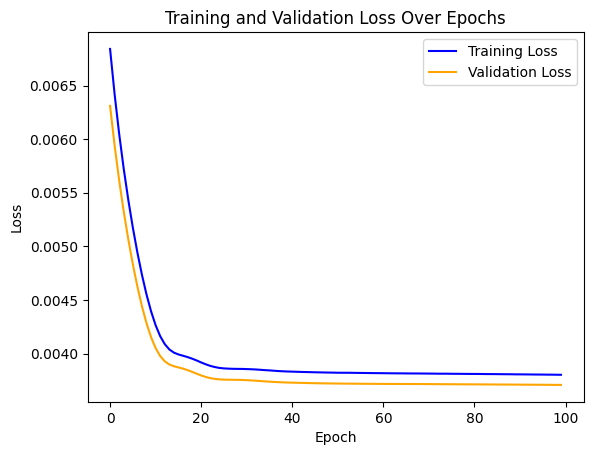

In [3]:
def scramble_state_vectors(encoded_data, seed):
    np.random.seed(seed)
    scrambled_vectors = []
    for i in range(len(encoded_data)):
        gaussian_matrix = np.random.normal(0, 0.1, (16, 16))
        scrambled_state = np.multiply(gaussian_matrix, encoded_data[i])
        scrambled_vectors.append(scrambled_state)
    return np.array(scrambled_vectors).reshape(len(encoded_data), 8, 8, 4)

class ClassicalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassicalDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
seed = 42

scrambled_states = scramble_state_vectors(data_X[:num_samples], seed=seed)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32).view(num_samples, -1)
encoded_data = torch.tensor(data_X[:num_samples], dtype=torch.float32).view(num_samples, -1)

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=seed, shuffle=True
)

model = ClassicalDiffusionModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states)
    train_loss = criterion(outputs, train_encoded_data)
    train_loss.backward()
    optimizer.step()
    train_loss_values.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states)
        val_loss = criterion(val_outputs, val_encoded_data)
        val_loss_values.append(val_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.5f}, Val Loss: {val_loss.item():.5f}')

plt.plot(train_loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Epoch [1/100], Train Loss: 0.00674, Val Loss: 0.00619
Epoch [2/100], Train Loss: 0.00634, Val Loss: 0.00586
Epoch [3/100], Train Loss: 0.00602, Val Loss: 0.00558
Epoch [4/100], Train Loss: 0.00574, Val Loss: 0.00534
Epoch [5/100], Train Loss: 0.00549, Val Loss: 0.00511
Epoch [6/100], Train Loss: 0.00526, Val Loss: 0.00490
Epoch [7/100], Train Loss: 0.00505, Val Loss: 0.00470
Epoch [8/100], Train Loss: 0.00486, Val Loss: 0.00452
Epoch [9/100], Train Loss: 0.00468, Val Loss: 0.00435
Epoch [10/100], Train Loss: 0.00453, Val Loss: 0.00422
Epoch [11/100], Train Loss: 0.00441, Val Loss: 0.00411
Epoch [12/100], Train Loss: 0.00432, Val Loss: 0.00404
Epoch [13/100], Train Loss: 0.00425, Val Loss: 0.00398
Epoch [14/100], Train Loss: 0.00420, Val Loss: 0.00393
Epoch [15/100], Train Loss: 0.00415, Val Loss: 0.00389
Epoch [16/100], Train Loss: 0.00410, Val Loss: 0.00385
Epoch [17/100], Train Loss: 0.00406, Val Loss: 0.00382
Epoch [18/100], Train Loss: 0.00402, Val Loss: 0.00379
Epoch [19/100], Tra

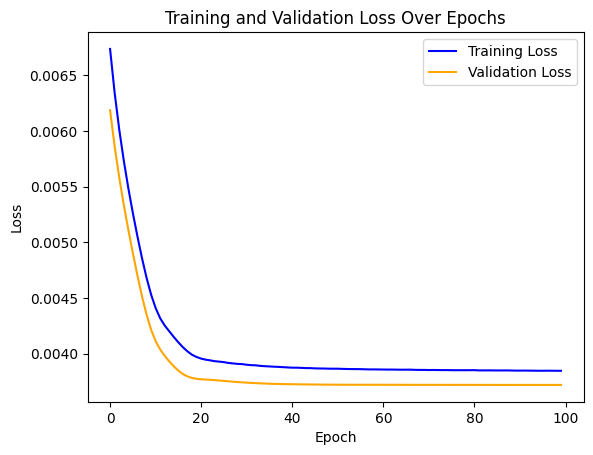

In [4]:
class ClassicalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(ClassicalDiffusionModel, self).__init__()
        self.n_layers = n_layers
        
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)])
        
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < self.n_layers:
                x = torch.relu(x)
                x = self.dropout(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_layers = 4
seed = 42

scrambled_states = scramble_state_vectors(data_X[:num_samples], seed=seed)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32).view(num_samples, -1)
encoded_data = torch.tensor(data_X[:num_samples], dtype=torch.float32).view(num_samples, -1)

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=seed, shuffle=True
)

model = ClassicalDiffusionModel(input_dim, hidden_dim, output_dim, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states)
    train_loss = criterion(outputs, train_encoded_data)
    train_loss.backward()
    optimizer.step()
    train_loss_values.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states)
        val_loss = criterion(val_outputs, val_encoded_data)
        val_loss_values.append(val_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.5f}, Val Loss: {val_loss.item():.5f}')

plt.plot(train_loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [5]:
denoised_states = model(scrambled_states).view(num_samples, 8, 8, 4).detach().numpy()

decoded_data = decode(denoised_states)
# decoded_data = flip(decoded_data)
print(decoded_data.shape)

mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(decoded_data)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID score: {fid}")

(10000, 16, 16)
FID score: 0.9765126528761661


In [6]:
num_samples_to_generate = 10000
new_images = generate_new_images(model, num_samples_to_generate)
# plot_mean_decoded_images(flip(new_images))
# plot_all_decoded_images(flip(new_images), grid_size=(10, 10))

In [7]:
generated_data = new_images

real_data = data_X[:len(generated_data)]

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(flip(generated_data))
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

wasserstein_value = calculate_wasserstein(real_data, flip(generated_data))
print("Wasserstein 1 ", wasserstein_value)

FID  0.9277479865749564
Wasserstein 1  0.012146205765940249


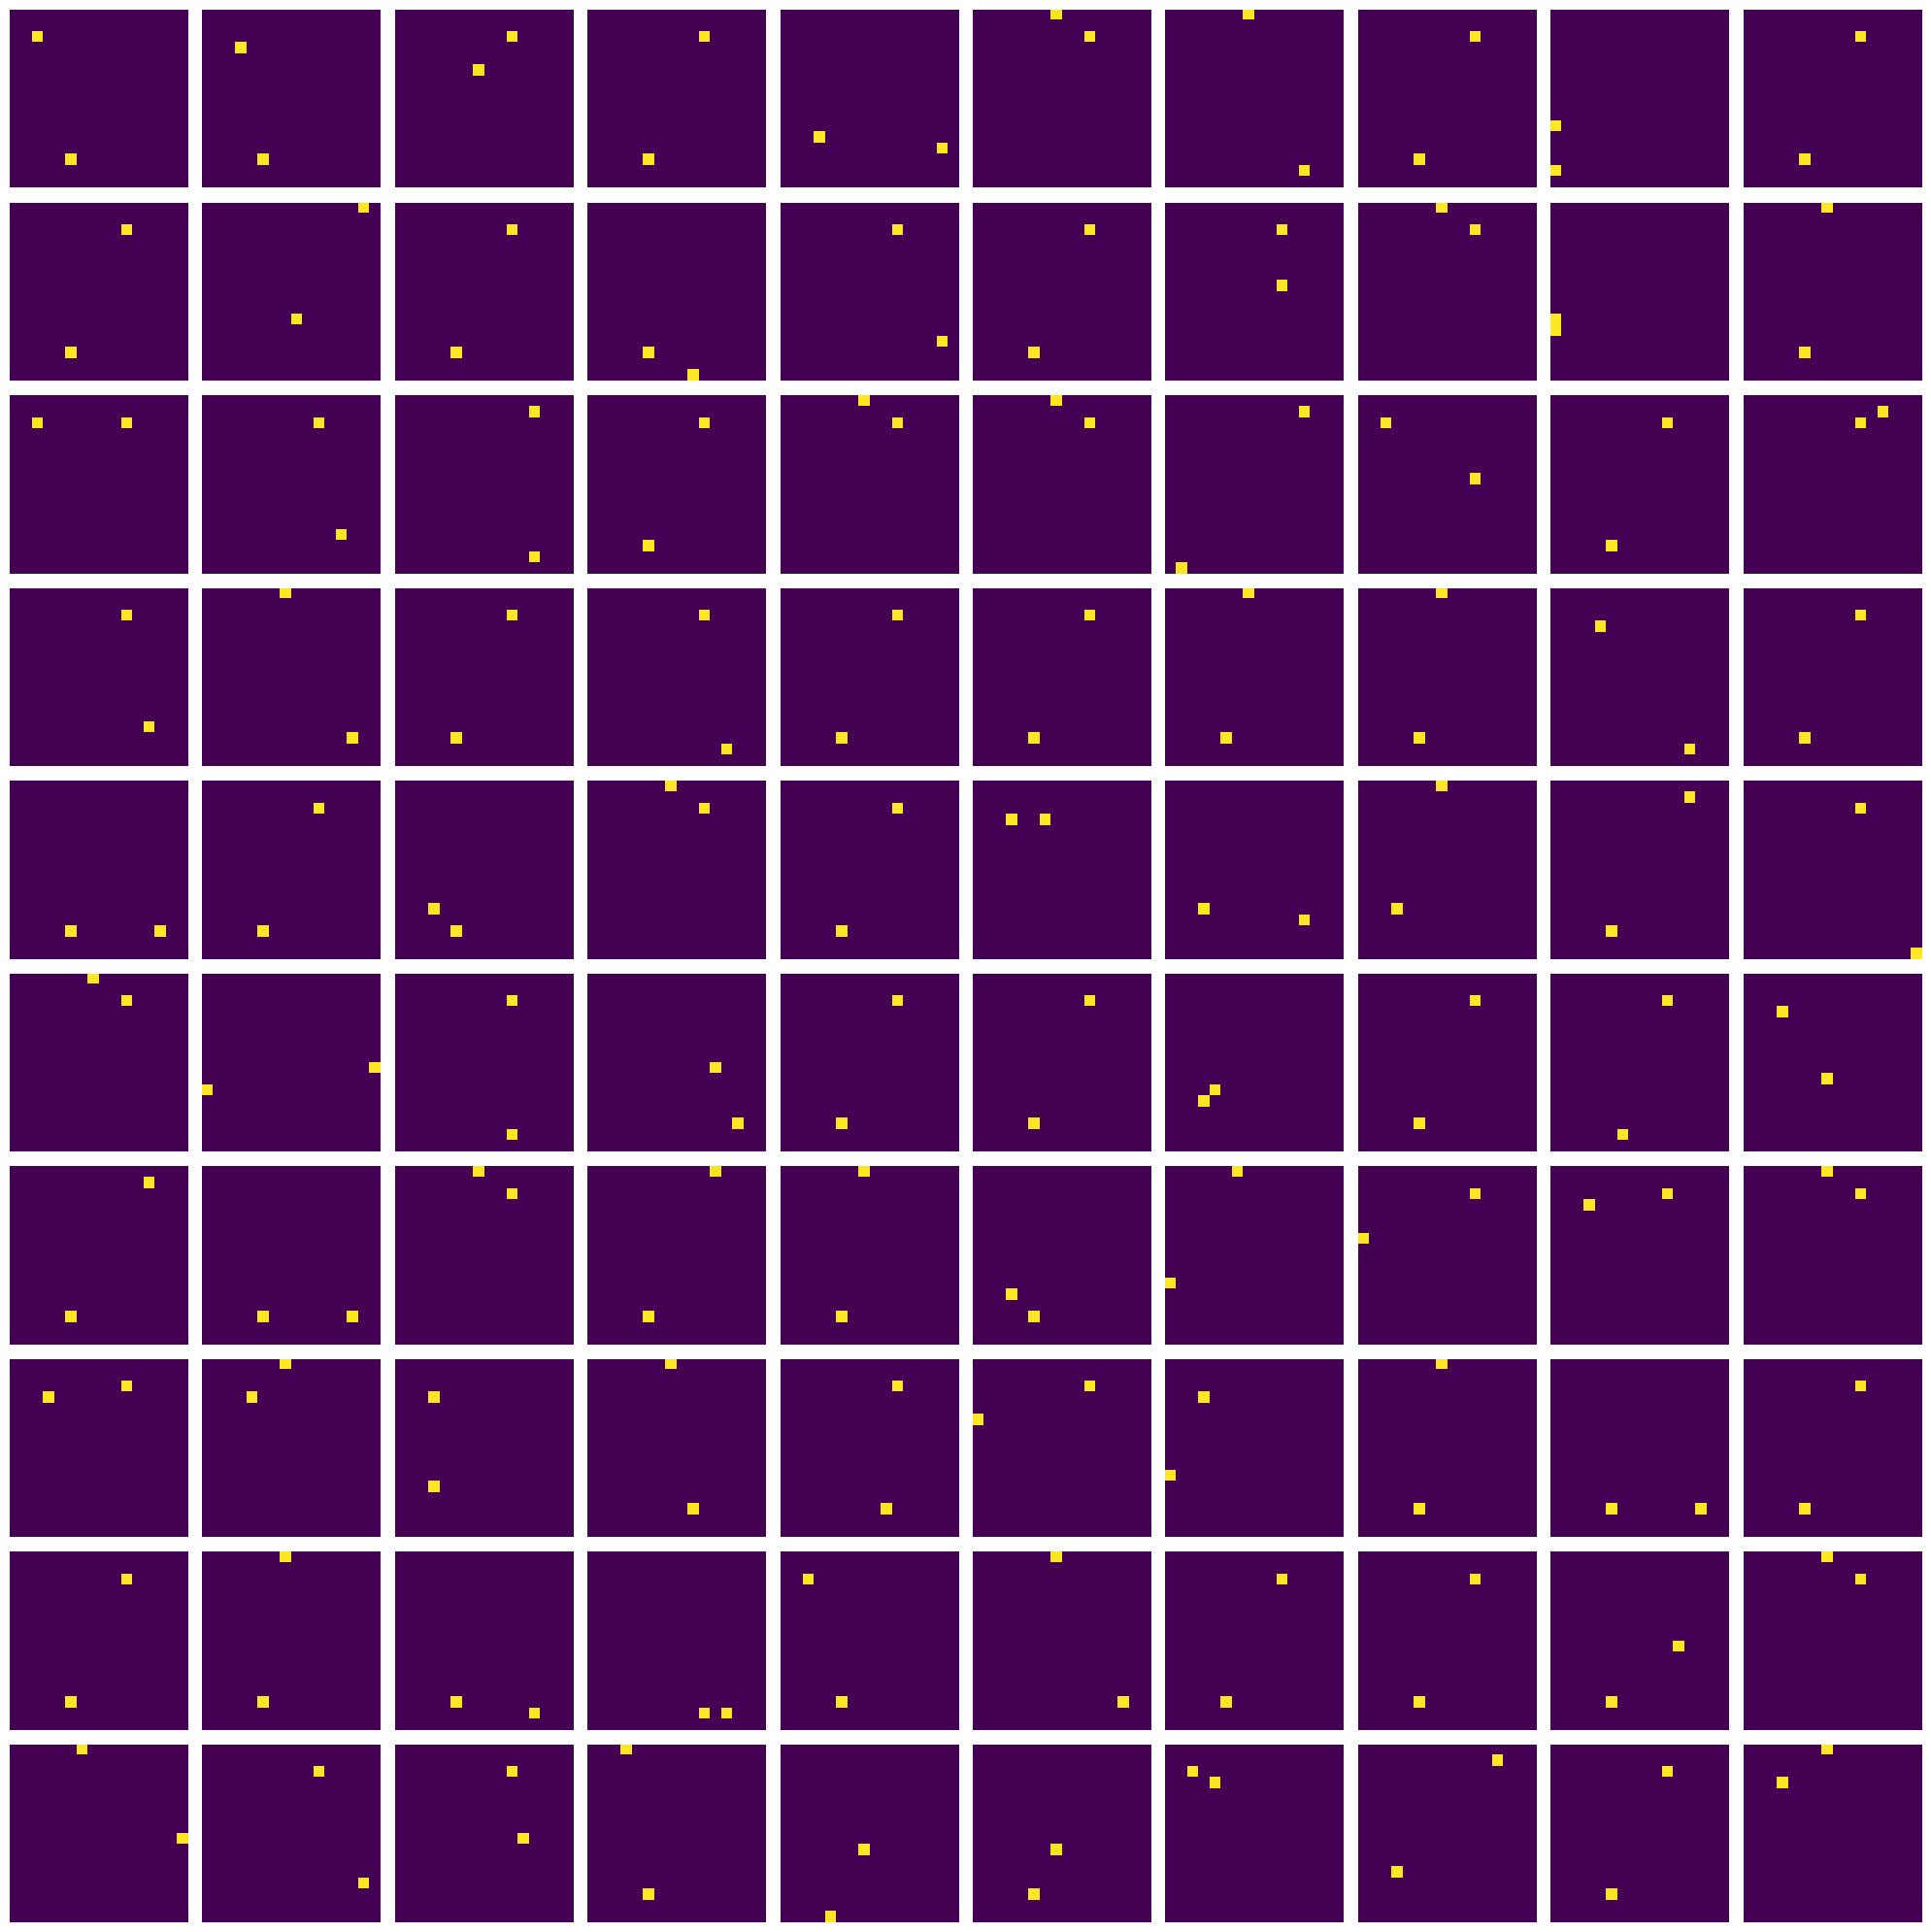

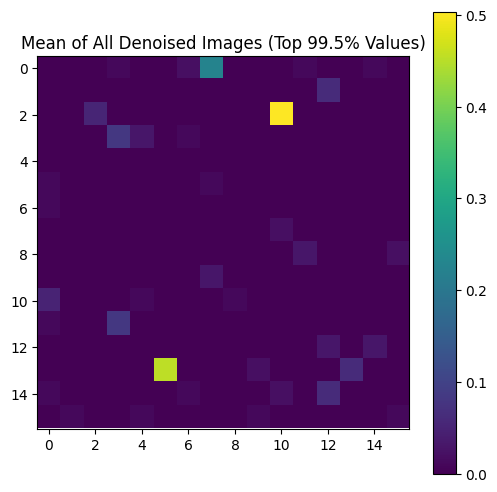

FID  3.362429318168699
Stable FID: 3.350257370262409
Wasserstein 1  0.004106354108080268


In [9]:
denoised_images = plot_decoded_images_without_noise(new_images, grid_size=(10, 10), threshold_percent=99.5)

limit = 10
real_data = real_data[:limit]
denoised_images = denoised_images[:limit]
mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid_stable(mu_real, sigma_real, mu_gen, sigma_gen)
print("Stable FID:", fid)

wasserstein_value = calculate_wasserstein(real_data, denoised_images)
print("Wasserstein 1 ", wasserstein_value)